# Evaluation of the 1D validation plate (exp101/JG406–408)

We have to make the predictions for this plate and compare to the experimental outcome

In [195]:
import pathlib
import sys

sys.path.append(str(pathlib.Path().resolve().parents[1]))

import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

from src.definitions import DATA_DIR
from src.util.db_utils import SynFermDatabaseConnection

In [196]:
con = SynFermDatabaseConnection()

In [197]:
# gather the experimental data
res = con.con.execute("SELECT e.id, vl_id, plate_nr, well, e.initiator_long, e.monomer_long, e.terminator_long, b.SMILES AS 'initiator', b2.SMILES AS 'monomer', b3.SMILES AS 'terminator', v.reaction_smiles_atom_mapped, product_A_lcms_ratio, product_B_lcms_ratio, product_C_lcms_ratio FROM experiments e LEFT JOIN virtuallibrary v on e.vl_id = v.id LEFT JOIN building_blocks b on e.initiator_long = b.long LEFT JOIN building_blocks b2 ON e.monomer_long = b2.long LEFT JOIN building_blocks b3 ON e.terminator_long = b3.long WHERE exp_nr = 101 AND (valid NOT LIKE 'ERROR%' OR valid IS NULL);").fetchall()
result = pd.DataFrame(res, columns=["id", "vl_id", "plate_nr", "well", "initiator_long", "monomer_long", "terminator_long", "initiator", "monomer", "terminator", "reaction_smiles_atom_mapped", "product_A_lcms_ratio", "product_B_lcms_ratio", "product_C_lcms_ratio"])
result["binary_A"] = (result["product_A_lcms_ratio"] > 0).astype(int)
result["binary_B"] = (result["product_B_lcms_ratio"] > 0).astype(int)
result["binary_C"] = (result["product_C_lcms_ratio"] > 0).astype(int)
result.head()

,id,vl_id,plate_nr,well,initiator_long,monomer_long,terminator_long,initiator,monomer,terminator,reaction_smiles_atom_mapped,product_A_lcms_ratio,product_B_lcms_ratio,product_C_lcms_ratio,binary_A,binary_B,binary_C
0,89314,2023878,1,A10,Ph037,Mon097,TerABT007,CS(=O)(=O)c1ccc(C(=O)[B-](F)(F)F)cc1.[K+],O=C1OC2(CCCCC2)O[C@@]12C[C@@H](c1cnco1)NO2,Nc1cc(Br)ccc1S,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.002873,0.0,0.0,1,0,0
1,89315,1991499,1,A11,Ph037,Spiro013,TerABT007,CS(=O)(=O)c1ccc(C(=O)[B-](F)(F)F)cc1.[K+],O=C(O[C@H]1CCOC1)N1CC2(C1)C[C@]1(O[NH2+]2)OC2(...,Nc1cc(Br)ccc1S,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.000814,0.0,0.0,1,0,0
2,89316,2013141,1,A12,Ph037,Spiro017,TerABT007,CS(=O)(=O)c1ccc(C(=O)[B-](F)(F)F)cc1.[K+],O=C1OC2(CCCCC2)O[C@@]12C[C@]1(CCCOC1)[NH2+]O2....,Nc1cc(Br)ccc1S,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.000783,0.0,0.0,1,0,0
3,89327,1952213,1,A3,Ph037,Fused005,TerABT007,CS(=O)(=O)c1ccc(C(=O)[B-](F)(F)F)cc1.[K+],Cl.O=C(OCc1ccccc1)N1C[C@@H]2NO[C@]3(OC4(CCCCC4...,Nc1cc(Br)ccc1S,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.001276,0.0,0.0,1,0,0
4,89328,2068899,1,A4,Ph037,Mon049,TerABT007,CS(=O)(=O)c1ccc(C(=O)[B-](F)(F)F)cc1.[K+],Cl.O=C1OC2(CCCCC2)O[C@@]12C[C@H](c1ccc(-c3cncn...,Nc1cc(Br)ccc1S,F[B-](F)(F)[C:1](=[O:2])[c:15]1[cH:16][cH:18][...,0.001873,0.0,0.0,1,0,0


In [198]:
# check how many of the 960 reactions were valid
len(result)

601

In [199]:
# export the reactants for prediction (will run on different machine)
result[["id", "initiator", "monomer", "terminator"]].to_csv("exp101_reactants.csv", index=False)


In [200]:
# load predictions
preds = pd.read_csv("exp101_predictions.csv")
preds.head()

,dim,pred_A,pred_B,pred_C
0,1D_I,1,1,0
1,1D_I,0,0,0
2,1D_I,0,0,0
3,1D_I,0,0,0
4,1D_I,1,0,0


In [201]:
# combine predictions and results
comb = result.join(preds)
comb.head()

,id,vl_id,plate_nr,well,initiator_long,monomer_long,terminator_long,initiator,monomer,terminator,...,product_A_lcms_ratio,product_B_lcms_ratio,product_C_lcms_ratio,binary_A,binary_B,binary_C,dim,pred_A,pred_B,pred_C
0,89314,2023878,1,A10,Ph037,Mon097,TerABT007,CS(=O)(=O)c1ccc(C(=O)[B-](F)(F)F)cc1.[K+],O=C1OC2(CCCCC2)O[C@@]12C[C@@H](c1cnco1)NO2,Nc1cc(Br)ccc1S,...,0.002873,0.0,0.0,1,0,0,1D_I,1,1,0
1,89315,1991499,1,A11,Ph037,Spiro013,TerABT007,CS(=O)(=O)c1ccc(C(=O)[B-](F)(F)F)cc1.[K+],O=C(O[C@H]1CCOC1)N1CC2(C1)C[C@]1(O[NH2+]2)OC2(...,Nc1cc(Br)ccc1S,...,0.000814,0.0,0.0,1,0,0,1D_I,0,0,0
2,89316,2013141,1,A12,Ph037,Spiro017,TerABT007,CS(=O)(=O)c1ccc(C(=O)[B-](F)(F)F)cc1.[K+],O=C1OC2(CCCCC2)O[C@@]12C[C@]1(CCCOC1)[NH2+]O2....,Nc1cc(Br)ccc1S,...,0.000783,0.0,0.0,1,0,0,1D_I,0,0,0
3,89327,1952213,1,A3,Ph037,Fused005,TerABT007,CS(=O)(=O)c1ccc(C(=O)[B-](F)(F)F)cc1.[K+],Cl.O=C(OCc1ccccc1)N1C[C@@H]2NO[C@]3(OC4(CCCCC4...,Nc1cc(Br)ccc1S,...,0.001276,0.0,0.0,1,0,0,1D_I,0,0,0
4,89328,2068899,1,A4,Ph037,Mon049,TerABT007,CS(=O)(=O)c1ccc(C(=O)[B-](F)(F)F)cc1.[K+],Cl.O=C1OC2(CCCCC2)O[C@@]12C[C@H](c1ccc(-c3cncn...,Nc1cc(Br)ccc1S,...,0.001873,0.0,0.0,1,0,0,1D_I,1,0,0


In [202]:
# evaluate for binary_A
print(f'Accuracy: {accuracy_score(comb["binary_A"], comb["pred_A"]):.2%}')
print(f'Precision: {precision_score(comb["binary_A"], comb["pred_A"]):.2%}')
print(f'Recall: {recall_score(comb["binary_A"], comb["pred_A"]):.2%}')
print(f'Confusion: {confusion_matrix(comb["binary_A"], comb["pred_A"])}')

Accuracy: 82.20%
Precision: 99.18%
Recall: 82.39%
Confusion: [[ 12   4]
 [103 482]]


In [203]:
# evaluate for binary_B
print(f'Accuracy: {accuracy_score(comb["binary_B"], comb["pred_B"]):.2%}')
print(f'Precision: {precision_score(comb["binary_B"], comb["pred_B"]):.2%}')
print(f'Recall: {recall_score(comb["binary_B"], comb["pred_B"]):.2%}')
print(f'Confusion: {confusion_matrix(comb["binary_B"], comb["pred_B"])}')

Accuracy: 91.35%
Precision: 95.82%
Recall: 91.07%
Confusion: [[182  16]
 [ 36 367]]


In [204]:
# evaluate for binary_C
print(f'Accuracy: {accuracy_score(comb["binary_C"], comb["pred_C"]):.2%}')
print(f'Precision: {precision_score(comb["binary_C"], comb["pred_C"]):.2%}')
print(f'Recall: {recall_score(comb["binary_C"], comb["pred_C"]):.2%}')
print(f'Confusion: {confusion_matrix(comb["binary_C"], comb["pred_C"])}')

Accuracy: 80.87%
Precision: 89.44%
Recall: 59.50%
Confusion: [[342  17]
 [ 98 144]]


In [205]:
# does this cluster by initiator?
for i in comb["initiator_long"].drop_duplicates():
    print(i)
    select = comb.loc[comb["initiator_long"] == i]
    print(f'Accuracy: {accuracy_score(select["binary_A"], select["pred_A"]):.2%}')
    print(f'Confusion: {confusion_matrix(select["binary_A"], select["pred_A"])}')

Ph037
Accuracy: 85.33%
Confusion: [[ 2  0]
 [11 62]]
Ph039
Accuracy: 85.00%
Confusion: [[ 1  0]
 [12 67]]
Ph040
Accuracy: 80.77%
Confusion: [[ 0  0]
 [15 63]]
Ph016
Accuracy: 86.08%
Confusion: [[ 4  1]
 [10 64]]
Ph041
Accuracy: 82.28%
Confusion: [[ 2  1]
 [13 63]]
Ph042
Accuracy: 80.77%
Confusion: [[ 0  0]
 [15 63]]
Ph011
Accuracy: 73.08%
Confusion: [[ 0  0]
 [ 7 19]]
BiAl005
Accuracy: 80.26%
Confusion: [[ 2  2]
 [13 59]]
Ph043
Accuracy: 76.67%
Confusion: [[ 1  0]
 [ 7 22]]


n.b. (because I keep forgetting) sklearn confusion matrix structure is [[tn fp]  [fn tp]]

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [206]:
# show the wells that had valid reactions in the plate layout
# n.b. we ignore the right half of the plate b/c all of that was invalid (oxalic acid transfer error)
arr = np.zeros((3, 16, 20), dtype=int)
for plate in comb["plate_nr"]:
    for well in comb.loc[comb["plate_nr"] == plate, "well"]:
        row = ord(well[0]) - 65
        col = int(well[1:]) - 3
        arr[plate-1, row, col] = 1
arr

array([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1,

In [207]:
# show the wells that had valid reactions in the plate layout
# n.b. we ignore the right half of the plate b/c all of that was invalid (oxalic acid transfer error)
arr = np.zeros((3, 16, 20), dtype=int)
for plate in comb["plate_nr"]:
    for well in comb.loc[comb["plate_nr"] == plate, "well"]:
        row = ord(well[0]) - 65
        col = int(well[1:]) - 3
        arr[plate-1, row, col] = 1
arr

array([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1,

<Axes: >

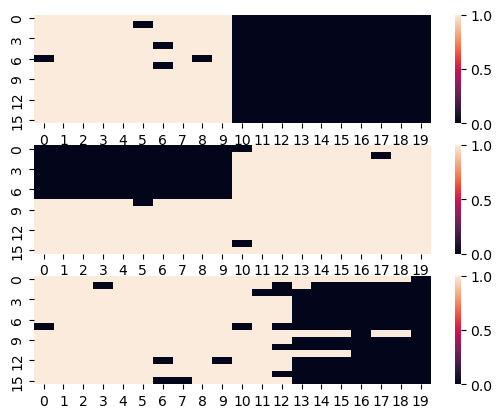

In [208]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3)
sns.heatmap(arr[0], ax=ax[0])
sns.heatmap(arr[1], ax=ax[1])
sns.heatmap(arr[2], ax=ax[2])

In [219]:
palette = sns.color_palette(["#e42536", "#f0f0f0", "#5790fc"])


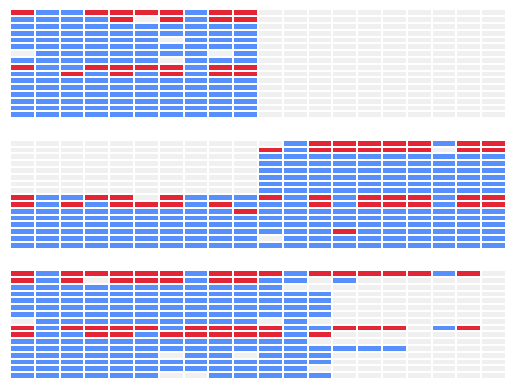

In [222]:
# show where we got it right for product A
arr = np.zeros((3, 16, 20), dtype=int)
for plate in comb["plate_nr"]:
    for i, dfrow in comb.loc[comb["plate_nr"] == plate].iterrows():
        row = ord(dfrow["well"][0]) - 65
        col = int(dfrow["well"][1:]) - 3
        if dfrow["pred_A"] == dfrow["binary_A"]:
            arr[plate-1, row, col] = 1
        else:
            arr[plate-1, row, col] = -1
fig, ax = plt.subplots(3)
sns.heatmap(arr[0], ax=ax[0], center=0, cmap=palette, cbar=False, linewidths=0.1)
sns.heatmap(arr[1], ax=ax[1], center=0, cmap=palette, cbar=False, linewidths=0.1)
sns.heatmap(arr[2], ax=ax[2], center=0, cmap=palette, cbar=False, linewidths=0.1)
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
fig.savefig("exp101_accuracyA.pdf", transparent=True)

#### Note
Note how almost all of the wrong predictions for A originate from the first two rows. Which building blocks are these?

In [210]:
comb.loc[comb["well"].str.startswith("A") | comb["well"].str.startswith("B"), "terminator_long"].drop_duplicates()

0     TerABT007
10    TerABT012
Name: terminator_long, dtype: object

In [211]:
from rdkit import Chem
from rdkit.Chem import Draw

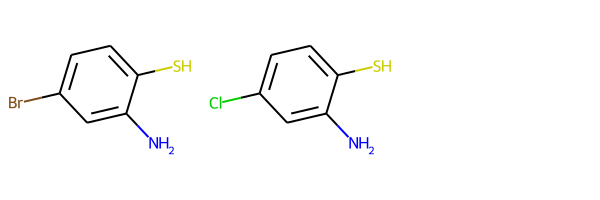

In [212]:
Draw.MolsToGridImage(
    [Chem.MolFromSmiles(con.get_smiles(long="TerABT007")), Chem.MolFromSmiles(con.get_smiles(long="TerABT012"))]
)

In [213]:
# average success rate for TerABT007
con.con.execute("SELECT AVG(product_A_lcms_ratio > 0) FROM experiments WHERE terminator_long = 'TerABT007' AND exp_nr BETWEEN 4 AND 29 AND (valid NOT LIKE 'ERROR%' OR valid IS NULL);").fetchone()

(0.5647899910634495,)

In [214]:
# average success rate for TerABT012
con.con.execute("SELECT AVG(product_A_lcms_ratio > 0) FROM experiments WHERE terminator_long = 'TerABT012' AND exp_nr BETWEEN 4 AND 29 AND (valid NOT LIKE 'ERROR%' OR valid IS NULL);").fetchone()

(0.7179161372299873,)

The success rate for TerABT007 is indeed markedly lower than for most building blocks giving a hint to why this may have been predicted not to work. For TerABT012 however that is less true. Still the high structural similarity to TerABT007 may play a role.

<Axes: >

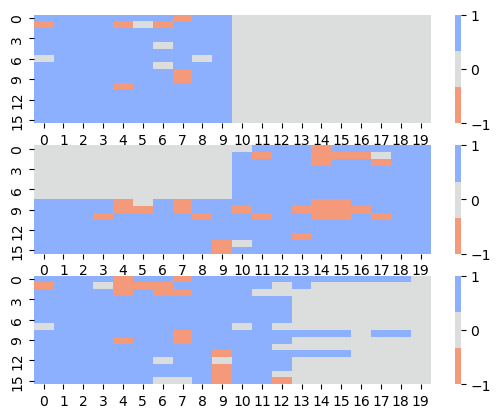

In [215]:
# show where we got it right for product B
arr = np.zeros((3, 16, 20), dtype=int)
for plate in comb["plate_nr"]:
    for i, dfrow in comb.loc[comb["plate_nr"] == plate].iterrows():
        row = ord(dfrow["well"][0]) - 65
        col = int(dfrow["well"][1:]) - 3
        if dfrow["pred_B"] == dfrow["binary_B"]:
            arr[plate-1, row, col] = 1
        else:
            arr[plate-1, row, col] = -1
fig, ax = plt.subplots(3)
sns.heatmap(arr[0], ax=ax[0], center=0, cmap=sns.color_palette("coolwarm_r", n_colors=3))
sns.heatmap(arr[1], ax=ax[1], center=0, cmap=sns.color_palette("coolwarm_r", n_colors=3))
sns.heatmap(arr[2], ax=ax[2], center=0, cmap=sns.color_palette("coolwarm_r", n_colors=3))

<Axes: >

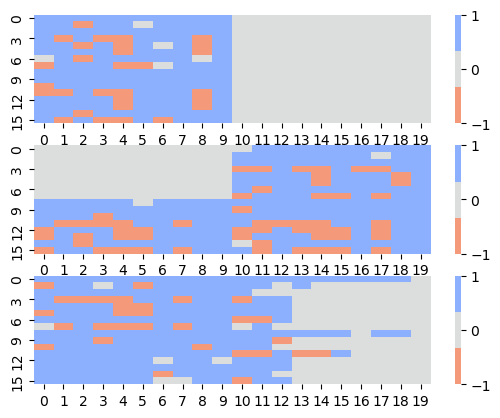

In [216]:
# show where we got it right for product C
arr = np.zeros((3, 16, 20), dtype=int)
for plate in comb["plate_nr"]:
    for i, dfrow in comb.loc[comb["plate_nr"] == plate].iterrows():
        row = ord(dfrow["well"][0]) - 65
        col = int(dfrow["well"][1:]) - 3
        if dfrow["pred_C"] == dfrow["binary_C"]:
            arr[plate-1, row, col] = 1
        else:
            arr[plate-1, row, col] = -1
fig, ax = plt.subplots(3)
sns.heatmap(arr[0], ax=ax[0], center=0, cmap=sns.color_palette("coolwarm_r", n_colors=3))
sns.heatmap(arr[1], ax=ax[1], center=0, cmap=sns.color_palette("coolwarm_r", n_colors=3))
sns.heatmap(arr[2], ax=ax[2], center=0, cmap=sns.color_palette("coolwarm_r", n_colors=3))